In [22]:
import pandas as pd

general_tweets = pd.read_excel('general-tweet-processed.xlsx')
keyword_tweets = pd.read_excel('keyword-tweet-processed.xlsx')

combined_data = pd.concat([general_tweets, keyword_tweets], ignore_index=True)

combined_data.head()


,Symbol,Text,Preprocessed Text
0,NOT,Bumping dj sefs mixtape nowww this is my music...,bumping dj sefs mixtape nowww music new skooooool
1,NOT,#ieroween THE STORY OF IEROWEEN! THE VIDEO ->>...,ieroween story ieroween video httpbitlyvfpav f...
2,NOT,trick or treating at the mall today; ZOO! last...,trick treating mall today zoo last year leftov...
3,NOT,@Ussk81 PMSL!!! I try not to stare but I can't...,ussk pmsl try stare cant help like compulsive ...
4,NOT,@Sc0rpi0n676 btw - is there a remote chance i ...,scrpin btw remote chance see later


In [23]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

combined_data['Preprocessed Text'] = combined_data['Preprocessed Text'].fillna('')

count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(combined_data['Preprocessed Text'])

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(combined_data['Preprocessed Text'])

df_bow = pd.DataFrame(X_bow.toarray(), columns=count_vectorizer.get_feature_names_out())
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())



In [24]:
from textblob import TextBlob

def get_sentiment_score(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

combined_data['Sentiment Score'] = combined_data['Preprocessed Text'].apply(get_sentiment_score)


In [25]:
from transformers import BertTokenizer, BertModel
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

combined_data['BERT Embeddings'] = combined_data['Preprocessed Text'].apply(lambda x: get_bert_embeddings(x).squeeze())


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

combined_data['Preprocessed Text'] = combined_data['Preprocessed Text'].fillna('')

tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(combined_data['Preprocessed Text'])

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)  # Explicitly set n_init to suppress the warning
kmeans_labels = kmeans.fit_predict(X_tfidf)

silhouette_avg = silhouette_score(X_tfidf, kmeans_labels)
db_index = davies_bouldin_score(X_tfidf.toarray(), kmeans_labels)  # Convert to dense array


In [27]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_tfidf)


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, combined_data['Symbol'], test_size=0.2, random_state=42)


In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)


In [30]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)


In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)


In [32]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=300)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)


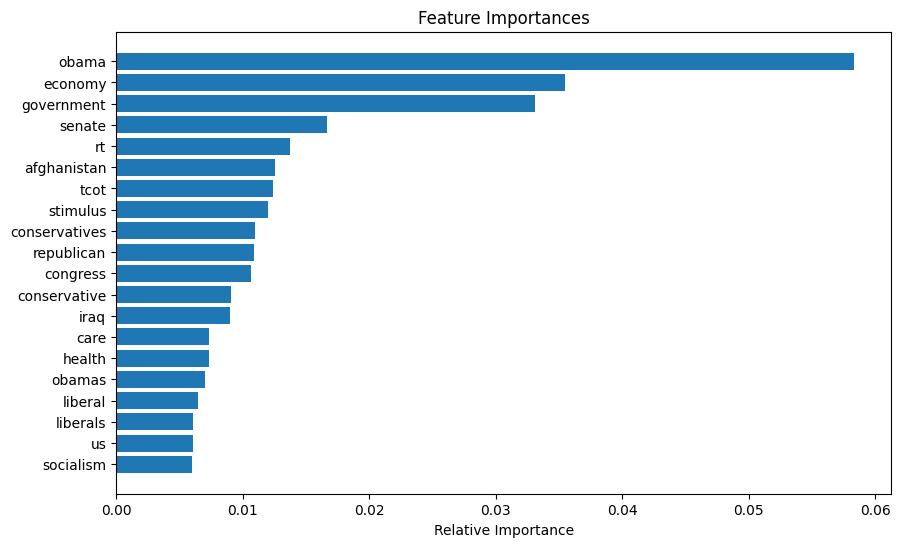

In [33]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [tfidf_vectorizer.get_feature_names_out()[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [34]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"Best parameters for Random Forest: {best_params}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Random Forest: {'max_depth': 30, 'n_estimators': 200}


In [35]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(n_estimators=100)
ada_boost.fit(X_train, y_train)
ada_boost_pred = ada_boost.predict(X_test)


In [36]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier())
]
stacking = StackingClassifier(estimators=estimators, final_estimator=SVC())
stacking.fit(X_train, y_train)
stacking_pred = stacking.predict(X_test)


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

combined_data['Cluster'] = kmeans_labels

X_combined = pd.concat([pd.DataFrame(X_tfidf.toarray()), pd.DataFrame(combined_data['Cluster'], columns=['Cluster'])], axis=1)

X_combined.columns = X_combined.columns.astype(str)

X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, combined_data['Symbol'], test_size=0.2, random_state=42)

rf_combined = RandomForestClassifier()
rf_combined.fit(X_train_combined, y_train_combined)

rf_combined_pred = rf_combined.predict(X_test_combined)

print(f"Predictions: {rf_combined_pred}")

Predictions: ['NOT' 'POLIT' 'POLIT' 'NOT' 'POLIT' 'POLIT' 'POLIT' 'POLIT' 'POLIT' 'NOT'
 'NOT' 'NOT' 'NOT' 'POLIT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'POLIT'
 'NOT' 'POLIT' 'NOT' 'POLIT' 'NOT' 'NOT' 'POLIT' 'NOT' 'NOT' 'NOT' 'POLIT'
 'NOT' 'NOT' 'NOT' 'NOT' 'POLIT' 'NOT' 'POLIT' 'POLIT' 'NOT' 'POLIT' 'NOT'
 'NOT' 'NOT' 'POLIT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'POLIT' 'POLIT'
 'NOT' 'POLIT' 'POLIT' 'NOT' 'NOT' 'POLIT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT'
 'NOT' 'POLIT' 'NOT' 'NOT' 'NOT' 'POLIT' 'NOT' 'POLIT' 'NOT' 'NOT' 'NOT'
 'POLIT' 'POLIT' 'NOT' 'NOT' 'NOT' 'NOT' 'POLIT' 'POLIT' 'NOT' 'NOT'
 'POLIT' 'NOT' 'POLIT' 'POLIT' 'NOT' 'POLIT' 'NOT' 'POLIT' 'POLIT' 'NOT'
 'POLIT' 'NOT' 'POLIT' 'POLIT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'POLIT'
 'POLIT' 'NOT' 'POLIT' 'POLIT' 'NOT' 'POLIT' 'NOT' 'NOT' 'POLIT' 'NOT'
 'NOT' 'POLIT' 'NOT' 'POLIT' 'NOT' 'NOT' 'POLIT' 'POLIT' 'NOT' 'NOT'
 'POLIT' 'NOT' 'POLIT' 'NOT' 'NOT' 'NOT' 'NOT' 'NOT' 'POLIT' 'NOT' 'POLIT'
 'POLIT' 'NOT' 'NOT' 'NOT' 'POLIT' 'NOT' 'NOT'

Logistic Regression - Accuracy: 0.8601747815230961, Precision: 0.8686010303212938, Recall: 0.8601747815230961, F1 Score: 0.8566942836605759
SVM - Accuracy: 0.8764044943820225, Precision: 0.8806213664917755, Recall: 0.8764044943820225, F1 Score: 0.8743731683635558
Random Forest - Accuracy: 0.898876404494382, Precision: 0.8995794027519076, Recall: 0.898876404494382, F1 Score: 0.898157611002569
Neural Network - Accuracy: 0.8589263420724095, Precision: 0.8627918126538149, Recall: 0.8589263420724095, F1 Score: 0.8564916314355264
AdaBoost - Accuracy: 0.8938826466916354, Precision: 0.8937601144005362, Recall: 0.8938826466916354, F1 Score: 0.8934969841827011
Stacking - Accuracy: 0.9101123595505618, Precision: 0.9107596496651328, Recall: 0.9101123595505618, F1 Score: 0.9102918545320974
RF Combined - Accuracy: 0.8976279650436954, Precision: 0.8986257634833471, Recall: 0.8976279650436954, F1 Score: 0.8968031581289824


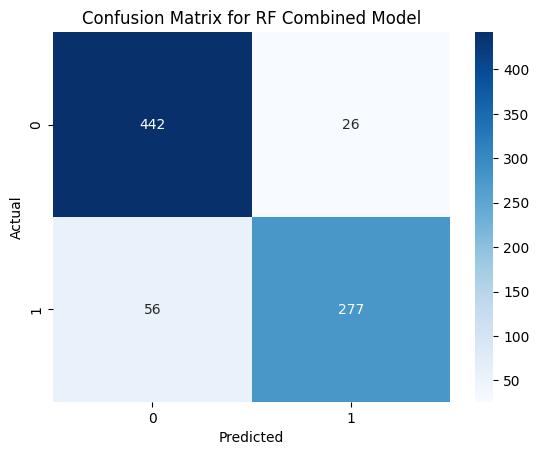

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'SVM', 'Random Forest', 'Neural Network', 'AdaBoost', 'Stacking', 'RF Combined']
predictions = [log_reg_pred, svm_pred, rf_pred, mlp_pred, ada_boost_pred, stacking_pred, rf_combined_pred]

for model, pred in zip(models, predictions):
    acc = accuracy_score(y_test_combined, pred)
    prec = precision_score(y_test_combined, pred, average='weighted')
    rec = recall_score(y_test_combined, pred, average='weighted')
    f1 = f1_score(y_test_combined, pred, average='weighted')
    print(f"{model} - Accuracy: {acc}, Precision: {prec}, Recall: {rec}, F1 Score: {f1}")

conf_matrix = confusion_matrix(y_test_combined, rf_combined_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RF Combined Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



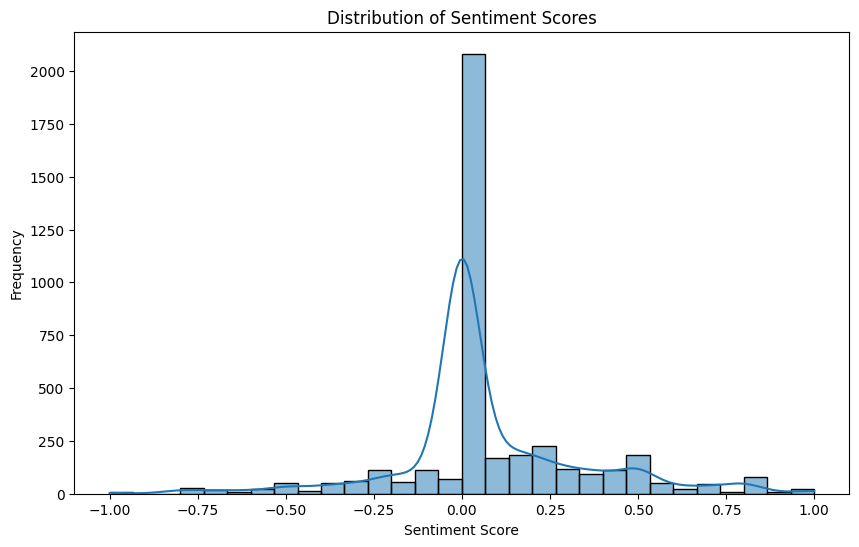

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(combined_data['Sentiment Score'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


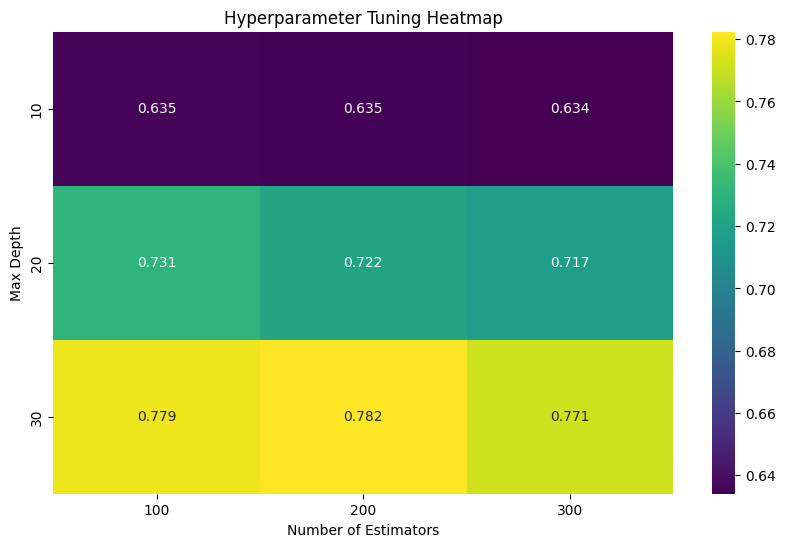

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

results = pd.DataFrame(grid_search.cv_results_)
scores = results.pivot(index='param_max_depth', columns='param_n_estimators', values='mean_test_score')

plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", cmap="viridis")
plt.title('Hyperparameter Tuning Heatmap')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()
